In [2]:
"""
numpy           1.25.2
opencv-python   4.8.0.74
pip             22.3.1

"""

import cv2
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import time
import os
import numpy as np

def wait_(tim):
    time.sleep(tim*0.3)
    print(".")
    time.sleep(tim*0.3)
    print(".")
    time.sleep(tim*0.3)
    print(".")

# Generate a Charuco Board

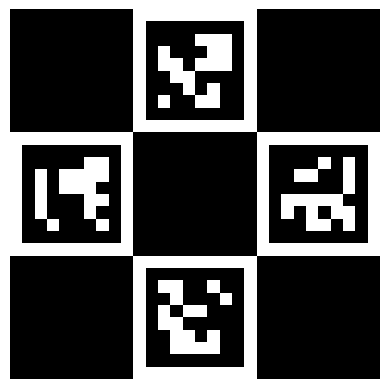

Imprimer le damier de calibration!


In [3]:
# FROM : https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/Projet+calibration-Paul.html

imagesFolder = "./data/CharucoBoard"                                                  
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)                 # Dictionary
board = cv2.aruco.CharucoBoard((3,3) , 1, 0.8, aruco_dict)                             # Charuco Board Constructor
imboard = board.generateImage((4000, 4000))                                            # Image to print
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
cv2.imwrite(imagesFolder + "/chessboard.tiff",imboard)                                 # Store the Board on Folder to print
plt.savefig(imagesFolder + "/chessboard.pdf")
plt.grid()
plt.show()
print("Imprimer le damier de calibration!")

# IMPORT THE CALIBRATION VIDEO

In [4]:

VIDFile = 'data/CharucoCalibVID.mp4'                        # Video File
imgs_folder = "./data/imgs/"                                # Folder to store the images from the calibration Video
capture = cv2.VideoCapture(VIDFile)

Nframes = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))        # Number of frames in the Video File
# Nframes/30                                                 # Time duration of Video File

## Take 150 frames from the Video File independent from duration

In [5]:
MAX_FRAMES = 150                                      # Define the maximum number of frames to capture
COUNT = int(Nframes / MAX_FRAMES)                     # COUNTER
COUNT

4

In [6]:
fps = capture.get(5)                                                             # Frame rate
print("INITIALIZING CAPTURE OF IMGS FROM SOURCE VIDEO")
while(capture.isOpened()):                                                       # Open Capture
    frameID = capture.get(1)                                                     # Get one frame
    ret, frame = capture.read()
    if(ret != True):
        break
    if(frameID % COUNT == 0 and frameID < Nframes):                              # Chosen frame (Uniform Sampling) 
        print(frameID)
        filename = imgs_folder + "image_" + str(int(frameID)) + ".jpg"           # Name of img file
        cv2.imwrite(filename, frame)                                             # Write img on system
    
capture.release()                                                                # Release VID  
print("DONE!")

INITIALIZING CAPTURE OF IMGS FROM SOURCE VIDEO
0.0
4.0
8.0
12.0
16.0
20.0
24.0
28.0
32.0
36.0
40.0
44.0
48.0
52.0
56.0
60.0
64.0
68.0
72.0
76.0
80.0
84.0
88.0
92.0
96.0
100.0
104.0
108.0
112.0
116.0
120.0
124.0
128.0
132.0
136.0
140.0
144.0
148.0
152.0
156.0
160.0
164.0
168.0
172.0
176.0
180.0
184.0
188.0
192.0
196.0
200.0
204.0
208.0
212.0
216.0
220.0
224.0
228.0
232.0
236.0
240.0
244.0
248.0
252.0
256.0
260.0
264.0
268.0
272.0
276.0
280.0
284.0
288.0
292.0
296.0
300.0
304.0
308.0
312.0
316.0
320.0
324.0
328.0
332.0
336.0
340.0
344.0
348.0
352.0
356.0
360.0
364.0
368.0
372.0
376.0
380.0
384.0
388.0
392.0
396.0
400.0
404.0
408.0
412.0
416.0
420.0
424.0
428.0
432.0
436.0
440.0
444.0
448.0
452.0
456.0
460.0
464.0
468.0
472.0
476.0
480.0
484.0
488.0
492.0
496.0
500.0
504.0
508.0
512.0
516.0
520.0
524.0
528.0
532.0
536.0
540.0
544.0
548.0
552.0
556.0
560.0
564.0
568.0
572.0
576.0
580.0
584.0
588.0
592.0
596.0
600.0
604.0
608.0
612.0
616.0
620.0
624.0
628.0
632.0
636.0
640.0
644.0
648.0
652

# Now, from the selected frames, we shall calibrate the camera parameters

This will take some time (about 13min)

In [ ]:
# FROM : https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/Projet+calibration-Paul.html

board = cv2.aruco.CharucoBoard((3,3) , 1, 0.8, aruco_dict)                # Same Charuco Board      


# THE FUNCTIONS
def read_chessboard(imgs):                                                # Identify the Charuco board on the image frame
    print("CHARUCO POSE ESTIMATION STARTING")
    wait_(1)
    allCorners = []
    allIDS = []
    decimator = 0

    for i in imgs:
        print("=> Processing image {0}".format(i))
        frame = cv2.imread(i)
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        #parameters =  cv2.aruco.DetectorParameters()
        #res = cv2.aruco.ArucoDetector(aruco_dict, parameters)
        res = cv2.aruco.detectMarkers(gray, aruco_dict )

        if(len(res[0]) > 0):
            res2 = cv2.aruco.interpolateCornersCharuco(res[0], res[1], gray, board)
            if(     res2[1] is not None 
                        and res2[2] is not None 
                        and len(res2[1]) > 3
                        and decimator%1==0):
                allCorners.append(res2[1])
                allIDS.append(res2[2])

        decimator+=1        

    img_size = gray.shape
    print("finished")
    return allCorners, allIDS, img_size

def calibrate_camera(allCorners,allIds,imsize):                            # Get the parameters (Intrinsic and Extrinsics)
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-6))

    print("finished")
    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors


# THE PROCESS
images = [imgs_folder + f for f in os.listdir(imgs_folder) if f.startswith("image_")]           # Select the images from Folder

allCorners, allIDS, imsize = read_chessboard(images)                                            # Identify the Board on Images

ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners, allIDS, imsize)                     # Get calibration Parameters

print(mtx)
print(ret)
print(dist)
np.savetxt(imgs_folder+"calib_mtx_cellcamVID.csv", mtx)                                         # Save Matrix 
np.savetxt(imgs_folder+"calib_dist_cellcamVID.csv", dist)                                       # Save Distortion Parameters


## With the camera matrix and the distortion parameters ready, is possible to proceed with the calibration check and then use the Aruco Pose Estimation Module

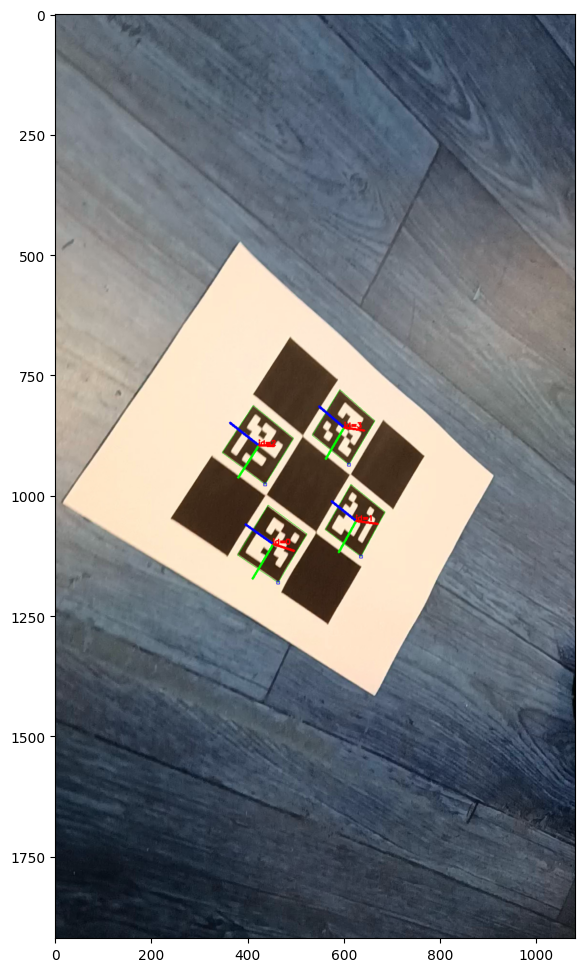

In [7]:

# CAMERA MATRIX                -> mtx                 (MINE: Felipe Jordao)
# 2.068268675143158816e+03 0.000000000000000000e+00 9.864133721217920083e+02
# 0.000000000000000000e+00 2.162385610454082780e+03 5.558514673165518616e+02
# 0.000000000000000000e+00 0.000000000000000000e+00 1.000000000000000000e+00

# DISTORTION PARAMETERS        -> dist                (MINE: Felipe Jordao)     
# -4.344115590524044168e-01
# 5.946729271049551180e-01
# 2.404662846493914666e-02
# -6.525542953777989374e-02
# 3.666177449982374714e+00
# 5.919204966661361089e-01
# -1.897748795248646259e+00
# 7.758460492255061069e+00
# 0.000000000000000000e+00
# 0.000000000000000000e+00
# 0.000000000000000000e+00
# 0.000000000000000000e+00
# 0.000000000000000000e+00
# 0.000000000000000000e+00

# DECLARE

mtx = np.array([[2.068268675143158816e+03, 0.000000000000000000e+00, 9.864133721217920083e+02],
                [0.000000000000000000e+00, 2.162385610454082780e+03, 5.558514673165518616e+02],
                [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]])

dist = np.array([[-4.344115590524044168e-01],
                 [5.946729271049551180e-01],
                 [2.404662846493914666e-02],
                 [-6.525542953777989374e-02],
                 [3.666177449982374714e+00],
                 [5.919204966661361089e-01],
                 [-1.897748795248646259e+00],
                 [7.758460492255061069e+00],
                 [0.000000000000000000e+00],
                 [0.000000000000000000e+00],
                 [0.000000000000000000e+00],
                 [0.000000000000000000e+00],
                 [0.000000000000000000e+00],
                 [0.000000000000000000e+00]])

# CHECK CALIBRATION CODE SNIPPET

frame = cv2.imread(imgs_folder + "image_300.jpg")      # Choose the image frame

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  cv2.aruco.DetectorParameters()
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
size_of_marker =   0.0145 # side lenght of the marker in meter
rvecs,tvecs, trash = cv2.aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)


frame_markers = cv2.aruco.drawDetectedMarkers(frame.copy(), corners, ids)

length_of_axis = 0.01
imaxis = cv2.aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = cv2.drawFrameAxes(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)




plt.figure(figsize = (12,12) )                                           # Show
plt.imshow(frame)
plt.imshow(imaxis)
#plt.figure()
#plt.imshow(frame_markers)
plt.show()

## Pose estimation

In [13]:
# FUNCTION FROM : https://github.com/GSNCodes/ArUCo-Markers-Pose-Estimation-Generation-Python/blob/main/pose_estimation.py

def pose_esitmation(frame, aruco_dict, matrix_coefficients, distortion_coefficients):

    '''
    frame - Frame from the video stream
    matrix_coefficients - Intrinsic matrix of the calibrated camera
    distortion_coefficients - Distortion coefficients associated with your camera

    return:-
    frame - The frame with the axis drawn on it
    '''

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    parameters = cv2.aruco.DetectorParameters()


    corners, ids, rejected_img_points = cv2.aruco.detectMarkers(gray, aruco_dict,parameters=parameters )

        # If markers are detected
    if len(corners) > 0:
        for i in range(0, len(ids)):
            # Estimate pose of each marker and return the values rvec and tvec---(different from those of camera coefficients)
            rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[i], 0.02, matrix_coefficients,
                                                                       distortion_coefficients)
            # Draw a square around the markers
            imaxis = cv2.aruco.drawDetectedMarkers(frame, corners) 

            # Draw Axis
            cv2.drawFrameAxes(imaxis, mtx, dist, rvec[i], tvec[i], 0.01)

    return frame

# THE PROCESS
'''
    mtx    -> matrix coefficients      / CAMERA INSTRINSIC
    dist   -> distortion coefficients  /
    
    rvec   -> rotation vectors         / OF EACH IDENTIFIED MARKER
    tvec   -> translation vectors      /
'''

while capture.isOpened():
    frameID = capture.get(1)
    ret, frame = capture.read()
    if(ret != True):
        break

    output = pose_esitmation(frame, aruco_dict, mtx, dist)
    # dsize
    scale_percent = 50
    width = int(output.shape[1] * scale_percent / 100)
    height = int(output.shape[0] * scale_percent / 100)
    dsize = (width, height)

    # resize image
    out2 = cv2.resize(output, dsize)
    print(frameID)
    cv2.imshow('Estimated Pode', out2)
    
    key = cv2.waitKey(1) & 0xFF
    if(key == ord('q')):
        break
capture.release()
cv2.destroyAllWindows()
